<a href="https://colab.research.google.com/github/microprediction/microprediction/blob/master/Election.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [587]:
# Data at https://github.com/TheEconomist/us-potus-model/tree/master/data
# Thank Andy Gelman and crew for open sourcing this. Shame on you Nate Silver for not doing the same :) 

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

polls16 = pd.read_csv('https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/all_polls.csv')
polls16['tmc'] = polls16['trump']-polls16['clinton']
polls16['end.date'] = pd.to_datetime(polls16['end.date'])
# Remove college from name to help difflib along
polls16['pollster'] = polls16['pollster'].apply( lambda name: name.replace('College','').replace("University","").replace('Research',''))
pollsters16 = list(set(polls16['pollster']))
print('There are '+str(len(pollsters16))+' pollsters in 2020')

There are 260 pollsters in 2020


In [588]:
# Parameters you can play with
SWING16 = 2   # Minimum percentage swing to Trump in 2016 before a pollster is considered prescient

### 1) Prescient Pollsters
Let's look at which polls picked up **changes** in Trump v. Clinton in the last stretch before 2016 election. This means that somehow their sampling methodology might have been lucky in some sense, in sofar as it selected more people who changed their minds towards Trump. It does not imply that the polls are accurate in an absolute sense. 

In [589]:
final16 = polls16.loc[ (polls16['start.date']>'2016-10-01') & (polls16['end.date']<'2016-11-08') & (polls16['population']=='Likely Voters'),:]
final16 = final16.sort_values(by='end.date')

changes16 = dict()
for pollster in pollsters16:
  final_polls16 = final16.loc[(final16['pollster']==pollster),:]
  if len(final_polls16['tmc'].values)>1:
    earliest = final_polls16['tmc'].values[0]
    latest = final_polls16['tmc'].values[-1]
    change = latest-earliest
    changes16[pollster]=change


print('Number of pollsters polling twice is '+str(len(changes16)))
prescience16 = [ (p,v) for p,v in changes16.items() if v>=SWING16]
print('Of these, the number predicting a swing to Trump of at least '+str(SWING16)+' was '+str(len(prescient16)))
prescient16 = [ p for p,v in prescience16]
print('Some examples of prescient pollsters...')
prescience16[:10]

Number of pollsters polling twice is 71
Of these, the number predicting a swing to Trump of at least 2 was 33
Some examples of prescient pollsters...


[('IBD/TIPP', 2),
 ('NYT Upshot/Siena', 7),
 ('Data Orbital (R)', 4),
 ('Loras ', 7),
 ('Lucid/The Times-Picayune', 3),
 ('UPI/CVOTER', 17),
 ('Siena', 7),
 ('NBC/WSJ/Marist', 12),
 ('Suffolk', 2),
 ('WashPost/SurveyMonkey', 12)]

We will call any other pollster a "deceived" pollster

In [590]:
deception16 = [ (p,v) for p,v in changes16.items() if v<SWING16]
deceived16 = [ p for p,_ in deception16]
deception16[:10]

[('CBS', -2),
 ('Magellan (R)', -1),
 ('SurveyUSA/KSN News', 0),
 ('SurveyUSA/TWC News North Carolina', 0),
 ('Opinion Savvy/Fox 5 Atlanta', 0),
 ('WISH-TV/Ball State ', 0),
 ('Saint Leo ', -3),
 ('RABA /Simpson', 1),
 ('Muhlenberg/Morning Call', 0),
 ('Baldwin Wallace ', 1)]

### 2) What do they say this time?
So what are the prescient and deceived polsters saying this time about ***changes*** in voting in recent weeks? 

In [591]:
polls20 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ56fySJKLL18Lipu1_i3ID9JE06voJEz2EXm6JW4Vh11zmndyTwejMavuNntzIWLY0RyhA1UsVEen0/pub?gid=0&single=true&output=csv')
polls20['tmc'] = polls20['trump']-polls20['biden']
polls20['end.date'] = polls20['end.date'].apply(lambda s: s.replace('108','10/8')) # Urgh
polls20['end.date'] = pd.to_datetime(polls20['end.date'])
polls20 = polls20.sort_values(by='end.date')
polls20['pollster'] = polls20['pollster'].apply( lambda name: name.replace('College','').replace('University','').replace('Research',''))
final20 = polls20.loc[ (polls20['start.date']>'2020-9-01') & (polls20['population']=='lv'),:]
final20 = final20.sort_values(by='end.date')
pollsters20=list(set(final20['pollster'].values))
print('There are '+str(len(pollsters20))+' pollsters in 2020')


There are 122 pollsters in 2020


In [592]:
import difflib
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def predictions(selected16):
  """ If supplied a list of pollsters from 2016, will show what they think in 2020  

       selected16 : [ str ]. list of pollsters from 2016
  """
  swing20 = list()   
  trump20 = dict()   #. pollster:trump lead
  for pollster20 in pollsters20:
      # Try to match current pollsters to previous 
      candidates16 = difflib.get_close_matches(pollster20, selected16,n=1) 
      if len(candidates16):
        if similar(candidates16[0],pollster20)>0.3:
            match16 = candidates16[0]
            print(match16 + ' -> ' + pollster20)
            # Look at polls this time around to see if swinging is detected
            late20   = final20.loc[(final20['pollster']==pollster20),:]
            latest20 = late20['tmc'].values[-1]
            trump20[pollster20]=latest20   # Most recent poll Trump-Biden differential,
                                  # but more relevant might be .. 
    
            if len(late20['tmc'].values)>1:
              # Compute the swing in 2020
              earliest20 = late20['tmc'].values[0]
              swing20.append(latest20-earliest20)
            
        else:
          print('No match for '+pollster20+ ' in the following list ')
          print(candidates16)
 
  plt.hist(swing20,bins=100)
  plt.xlabel('Trump Swing 2020')
  import numpy as np
  print("")
  trump_level = np.mean(list(trump20.values()))
  trump_swing = np.mean(swing20)
  print('Trump advantage '+str(trump_level))
  print('Trump swing mean '+str(trump_swing))
  print('Trump swing median '+str(np.median(swing20)))
  return swing20, trump20 



Christopher Newport -> Christopher Newport 
IBD/TIPP -> IBD/TIPP
Y2 Analytics (R) -> DKC Analytics
IBD/TIPP -> TIPP
Suffolk -> Suffolk 
Data Orbital (R) -> Data Orbital
SurveyUSA/KABC/SCNG -> SurveyUSA
CBS/YouGov -> YouGov
NYT Upshot/Siena -> NYT/Siena 
Siena -> Siena 
Y2 Analytics (R) -> Y2 Analytics
Quinnipiac -> Quinnipiac 

Trump advantage -6.833333333333333
Trump swing mean 1.0
Trump swing median 1.0


{'Christopher Newport ': -5,
 'DKC Analytics': -19,
 'Data Orbital': -2,
 'IBD/TIPP': -3,
 'NYT/Siena ': -7,
 'Quinnipiac ': 1,
 'Siena ': -22,
 'Suffolk ': -4,
 'SurveyUSA': -27,
 'TIPP': -13,
 'Y2 Analytics': 10,
 'YouGov': 9}

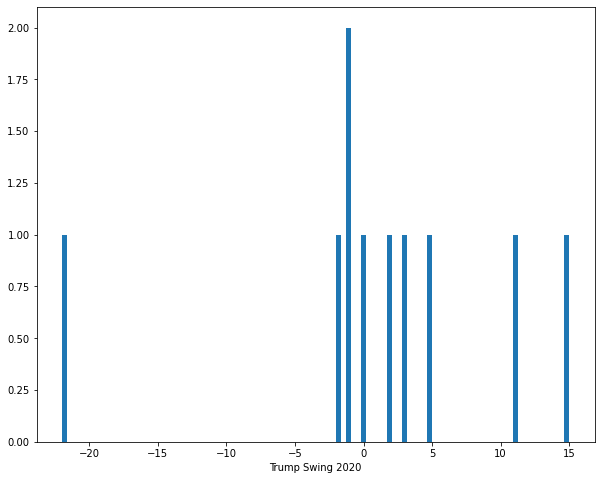

In [593]:
prescient16
prescient20_swings, prescient20_trump = predictions(selected16=prescient16)
prescient20_trump


On the other hand ...

Saint Leo  -> Saint Leo 
Fairleigh Dickinson -> Fairleigh Dickinson 
Baldwin Wallace  -> Baldwin Wallace 
Washington Post/GMU -> ABC News/Washington Post
Suffolk/USA Today -> Suffolk 
Remington  Group (R)/Axiom Strategies -> Remington  Group
Public Religion  Institute/The Atlantic -> Public Religion  Institute
Marquette Law School -> Marquette  Law School
SurveyUSA/KSTP-TV -> SurveyUSA
Roanoke  -> Roanoke 
Muhlenberg/Morning Call -> Muhlenberg 
Monmouth  -> Monmouth 
Politico/Morning Consult -> Morning Consult

Trump advantage -8.846153846153847
Trump swing mean -4.2
Trump swing median -2.5


{'ABC News/Washington Post': -9,
 'Baldwin Wallace ': 2,
 'Fairleigh Dickinson ': -15,
 'Marquette  Law School': -5,
 'Monmouth ': -10,
 'Morning Consult': -7,
 'Muhlenberg ': -4,
 'Public Religion  Institute': -13,
 'Remington  Group': 5,
 'Roanoke ': -14,
 'Saint Leo ': -14,
 'Suffolk ': -4,
 'SurveyUSA': -27}

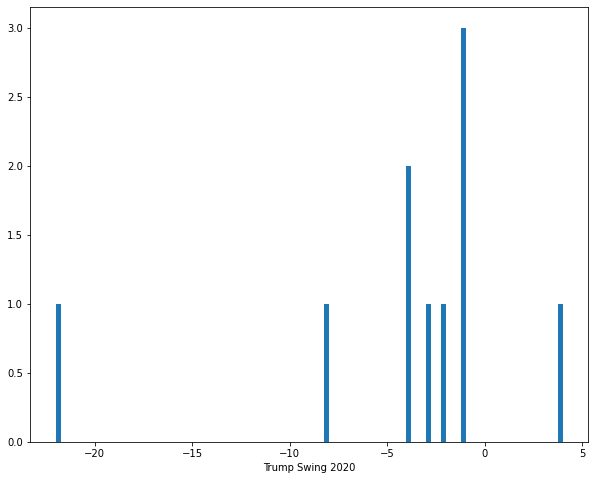

In [594]:
deceived20_swings, deceived20_trump = predictions(selected16=deceived16)
deceived20_trump

Text(0.5, 0, 'Swing to Trump')

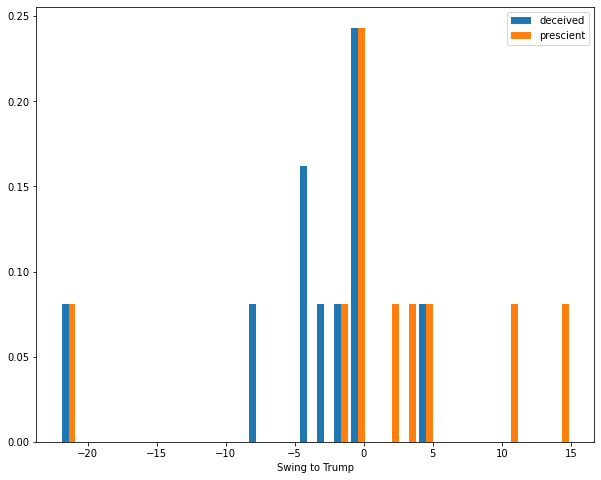

In [597]:
plt.hist([deceived20_swings,prescient20_swings], density=True, histtype='bar', bins=30)
plt.legend(['deceived','prescient'])
plt.xlabel('Swing to Trump')

Text(0.5, 0, 'Trump advantage')

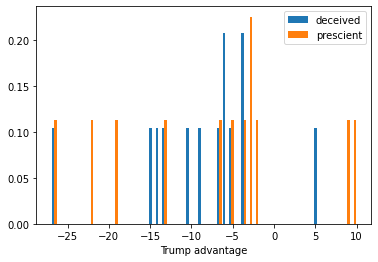

In [545]:

plt.hist([list(deceived20_trump.values()), list(prescient20_trump.values())], density=True, histtype='bar', bins=50)
plt.legend(['deceived','prescient'])
plt.xlabel('Trump advantage')

In [546]:
deceived20_trump

{'ABC News/Washington Post': -9,
 'Baldwin Wallace ': -6,
 'Fairleigh Dickinson ': -15,
 'Marquette  Law School': -5,
 'Monmouth ': -10,
 'Morning Consult': -7,
 'Muhlenberg ': -4,
 'Public Religion  Institute': -13,
 'Remington  Group': 5,
 'Roanoke ': -14,
 'Saint Leo ': -6,
 'Suffolk ': -4,
 'SurveyUSA': -27}

In [556]:
def show_pollster(selected20,lead):
  poll = polls20.loc[ (polls20['pollster']==selected20),:]
  plt.plot(poll['end.date'],poll['tmc'],'*')
  abs_lead = abs(lead)
  candidate = 'Biden' if lead<0 else 'Trump'
  plt.title(selected20+' ('+candidate+' by '+str(abs_lead)+')')
prescient20_trump

{'Christopher Newport ': -5,
 'DKC Analytics': -19,
 'Data Orbital': -2,
 'IBD/TIPP': -3,
 'NYT/Siena ': -7,
 'Quinnipiac ': -3,
 'Siena ': -22,
 'Suffolk ': -4,
 'SurveyUSA': -27,
 'TIPP': -13,
 'Y2 Analytics': 10,
 'YouGov': 9}

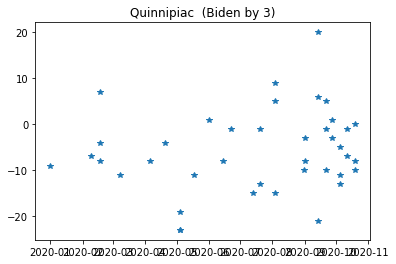

In [570]:
# Click this to show a random prescient pollster
import random 
pollster, swg = random.choice( list(prescient20_trump.items()) )
show_pollster(pollster,swg)

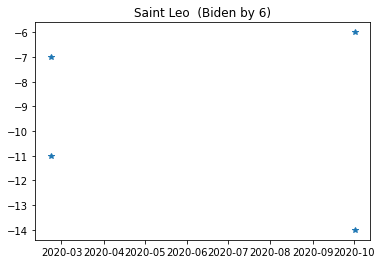

In [576]:
# Click this to show a random deceived pollster
import random 
pollster, swg = random.choice( list(deceived20_trump.items()) )
show_pollster(pollster,swg)